In [1]:
%pylab inline
import pandas as pd
import anndata

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

from scvi.dataset import GeneExpressionDataset
from scvi.models import LDVAE
from scvi.inference import UnsupervisedTrainer, Trainer
from scvi.inference.posterior import Posterior

from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger

In [3]:
datapath = 'C:/Users/vale/Google Drive/EBI/Research Projects/Ongoing/Huwe/Data/Hrvatin 2017/GSE102827_merged_all_raw.h5ad'

In [4]:
vcortex = anndata.read(datapath)

In [5]:
# Remove what's considered "noise" by the authors
vcortex = vcortex[vcortex.obs.query('maintype != "nan"').index]

In [6]:
vcortex

View of AnnData object with n_obs × n_vars = 48266 × 25187 
    obs: 'stim', 'sample', 'maintype', 'celltype', 'subtype'

In [7]:
X, local_means, local_vars, batch_indices, labels = GeneExpressionDataset.get_attributes_from_matrix(vcortex.X)

In [8]:
cells_dataset =\
GeneExpressionDataset(X, local_means, local_vars, batch_indices, labels,
                      gene_names=np.array(vcortex.var.index.values, dtype=str))

In [9]:
cells_dataset.subsample_genes(1000)

Downsampling from 25187 to 1000 genes
Downsampling from 48266 to 48266 cells


In [10]:
vae = LDVAE(cells_dataset.nb_genes,
            n_batch=cells_dataset.n_batches,
            n_latent=10,
            n_layers=3,
            n_hidden=128,
           )

In [11]:
trainer = UnsupervisedTrainer(vae,
                              cells_dataset,
                              frequency=1,
                              use_cuda=True
                             )

In [12]:
trainer.train(n_epochs=20)

training: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [03:48<00:00, 11.31s/it]


In [13]:
torch.cuda.empty_cache()

Populating the interactive namespace from numpy and matplotlib


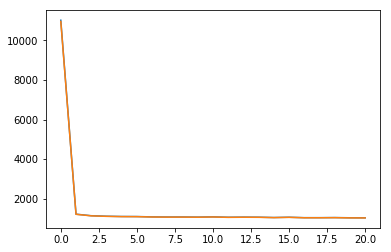

In [14]:
%pylab inline

figsize(6, 4)
plt.plot(trainer.history['ll_train_set'])
plt.plot(trainer.history['ll_test_set']);

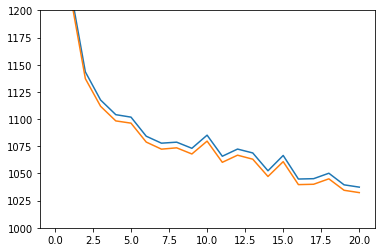

In [15]:
figsize(6, 4)
plt.plot(trainer.history['ll_train_set'])
plt.plot(trainer.history['ll_test_set']);
plt.ylim(top=1200, bottom=1000);

In [16]:
Z_hat = vae.sample_from_posterior_z(torch.from_numpy(cells_dataset.X.toarray()).float().to(0))
Z_hat = np.array(Z_hat.detach()).astype(double)

In [17]:
for i, z in enumerate(Z_hat.T):
    vcortex.obs[f'Z_{i}'] = z

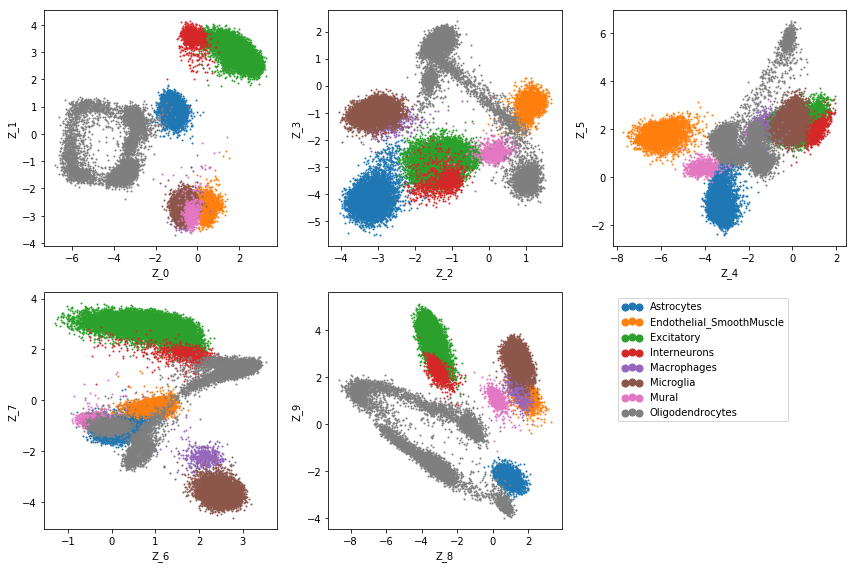

In [18]:
figsize(12, 8)

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)
    
    for c_, grp_ in vcortex.obs.groupby('maintype'):
        plt.scatter(grp_[f'Z_{f}'], grp_[f'Z_{f + 1}'], marker='.', label=c_, s=4)
        
    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')
    
plt.subplot(2, 3, 6)
for c_, grp_ in vcortex.obs.groupby('maintype'):
    sctrpl_ = plt.scatter(grp_[f'Z_{f}'], grp_[f'Z_{f + 1}'], marker='.', label=c_, s=4)
    
plt.scatter(vcortex.obs[f'Z_{f}'], vcortex.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [19]:
loadings = list(vae.decoder.factor_regressor.parameters())[0].cpu().detach().numpy()
loadings = \
pd.DataFrame.from_records(loadings, index=cells_dataset.gene_names,
                                    columns=[f'Z_{i}' for i in range(10)])

In [20]:
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
Plp1,-0.358564,0.121513,-0.004322,0.457151,-0.192963,0.023354,0.271584,-0.075700,-0.231164,-0.313380
Mbp,-0.444195,-0.060302,-0.123387,0.021690,0.191564,0.461019,0.098224,0.073862,-0.186103,-0.303027
Nrgn,0.294544,0.065442,-0.225273,0.032780,0.097219,0.056022,-0.177078,0.311773,-0.164329,0.194373
Meg3,0.024437,-0.057520,0.011279,-0.017638,0.260074,0.253377,0.029797,0.218095,-0.428655,0.280881
Hbb-bs,0.167557,-0.279236,0.139098,0.197379,-0.389688,-0.023370,0.180716,0.380185,0.474760,-0.122983


In [21]:
print('Top loadings by magnitude\n---------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------\n')

Top loadings by magnitude
---------------------
Z_0:	Cnp, -0.46	Mbp, -0.44	Cldn11, -0.42	Gpr17, -0.39	Tubb2b, -0.39
	...
	Egr4, 0.5	Arc, 0.5	Camkk2, 0.52	Nefm, 0.58	Nefl, 0.63
---------------------

Z_1:	Slc12a2, -0.54	Csf1r, -0.48	Gpr37, -0.46	Sept4, -0.45	Plat, -0.44
	...
	Atp1b1, 0.47	Tubb2b, 0.47	Atp2b4, 0.49	Pcdh7, 0.5	Cxcl14, 0.55
---------------------

Z_2:	Glul, -0.46	Fth1, -0.42	Cst3, -0.41	Mt1, -0.35	Ckb, -0.35
	...
	Ptprb, 0.63	Olig1, 0.68	Nov, 0.69	Pllp, 0.74	Pianp, 0.9
---------------------

Z_3:	Sparcl1, -0.55	Serpine2, -0.42	Tspan7, -0.39	Serpini1, -0.39	Rgs5, -0.39
	...
	Msto1, 0.48	Acad12, 0.5	Mobp, 0.51	Tmem2, 0.53	Ttll1, 0.62
---------------------

Z_4:	Hbb-bt, -0.49	Atp1a2, -0.45	Tm4sf1, -0.43	Glul, -0.41	Hba-a2, -0.41
	...
	Pcp4, 0.88	Npy, 0.93	Sst, 0.98	Vip, 0.99	Gad2, 1.2
---------------------

Z_5:	Mfge8, -0.64	Plat, -0.59	Ddr1, -0.57	Gpr37, -0.56	Luzp2, -0.54
	...
	Kif5b, 0.44	Rps29, 0.44	Mbp, 0.46	Gm20594, 0.48	Tpt1, 0.6
---------------------

Z_6:	Bdnf, -0.86

In [22]:
tsne = TSNE(callbacks=ErrorLogger(),
            initialization='random',
            negative_gradient_method='fft',
            callbacks_every_iters=100,
            neighbors='approx',
            n_jobs=-1)

YY = tsne.fit(Z_hat)

Iteration  100, KL divergence  5.7574, 100 iterations in 10.9218 sec
Iteration  200, KL divergence  5.2399, 100 iterations in 10.9168 sec
Iteration  100, KL divergence  3.8809, 100 iterations in 11.2748 sec
Iteration  200, KL divergence  3.4542, 100 iterations in 11.9620 sec
Iteration  300, KL divergence  3.2068, 100 iterations in 14.9929 sec
Iteration  400, KL divergence  3.0410, 100 iterations in 18.4028 sec
Iteration  500, KL divergence  2.9211, 100 iterations in 21.5434 sec
Iteration  600, KL divergence  2.8299, 100 iterations in 24.0676 sec
Iteration  700, KL divergence  2.7590, 100 iterations in 26.8711 sec


In [23]:
for i, y in enumerate(YY.T):
    vcortex.obs[f'tsne_{i}'] = y

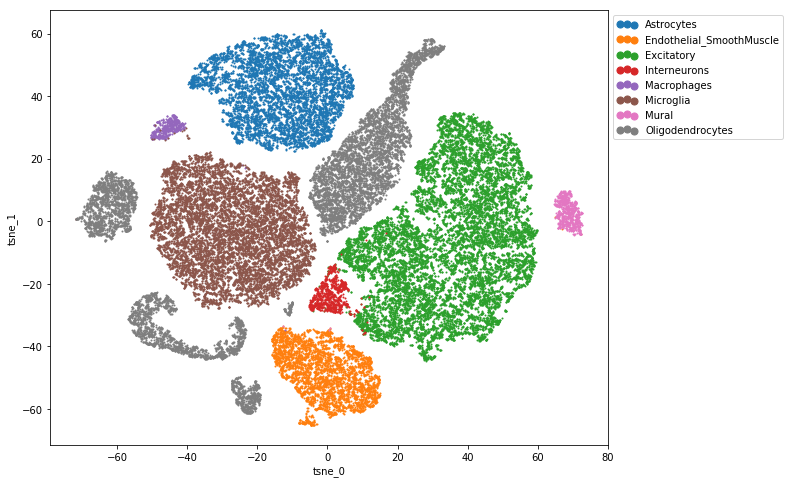

In [24]:
figsize(10, 8)

for c_, grp_ in vcortex.obs.groupby('maintype'):
    plt.scatter(grp_['tsne_0'], grp_['tsne_1'], marker='.', label=c_, s=4)
    
plt.xlabel('tsne_0')
plt.ylabel('tsne_1')
    
lgd = plt.legend(scatterpoints=3, loc='upper left', bbox_to_anchor=(1, 1))
for handle in lgd.legendHandles:
    handle.set_sizes([200])

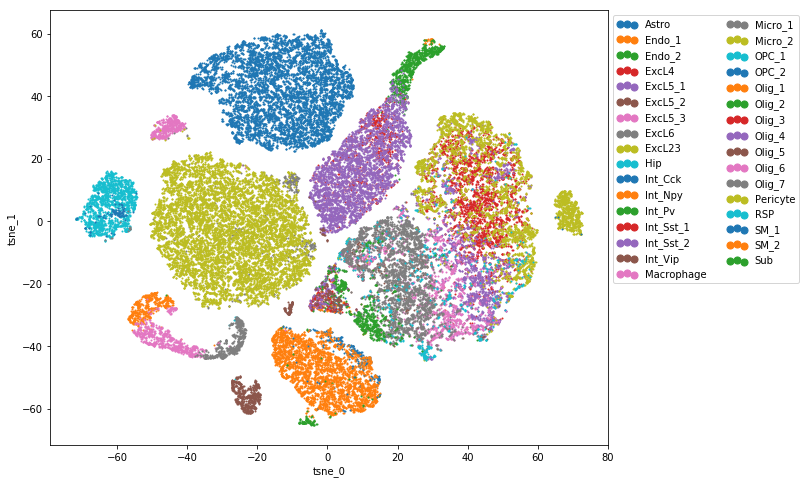

In [28]:
figsize(10, 8)

for c_, grp_ in vcortex.obs.groupby('celltype'):
    plt.scatter(grp_['tsne_0'], grp_['tsne_1'], marker='.', label=c_, s=4)
    
plt.xlabel('tsne_0')
plt.ylabel('tsne_1')
    
lgd = plt.legend(scatterpoints=3, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
for handle in lgd.legendHandles:
    handle.set_sizes([200])